In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

## Load the Data

In [3]:
# Define the path for the dataset file
file_path = './sonnets.txt'

# Open the Sonnets File
with open(file_path) as file:
    data = file.read()

# convert to lower case and save it as a list  
corpus = data.lower().split("\n")

# print the number of rows
print("There are {} lines of sonnets\n" .format(len(corpus)))

# show the first 5 lines of the corpus
print("The first 5 lines look like this: ")
for i in range(5):
    print(corpus[i])


There are 2159 lines of sonnets

The first 5 lines look like this: 
from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing Text and Generating n_grams

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []

    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_grams_sequences = token_list[:i+1]
            input_sequences.append(n_grams_sequences)
    
    return input_sequences


In [6]:
# show the exaple of input_sequences
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [7]:
# Apply the n_gram_seqs function to the whole corpus 
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save the maximum length of the sequence to use it on padding  
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add Padding to the Sequences

In [8]:
def pad_seqs(input_sequences, max_len):

    # padding the tokenized sequences into same length 
    padded_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='pre')

    return padded_sequences

In [9]:
# Test the function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]])

In [10]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the Data into Features and Label 

before feeding the data into the neural network, the tokenized sequences have to be splitted into features and label first, in wich features will be the padded n_gram sequences with the last word remover from them and label will the the removed word (word not used in features). The label should be encoded using one hot encoding method. Because every words in the corpus will be a label at least once, the total words is also needed.

In [11]:
def split_features_label(input_sequences, total_words):

    features = input_sequences[:,:-1]
    label = input_sequences[:,-1]
    one_hot_labels = to_categorical(label, num_classes=total_words)

    return features, one_hot_labels

In [12]:
# Split the whole corpus
features, labels = split_features_label(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the Model 



In [13]:
def create_model(total_words, max_sequence_len):
    
    #create the model architecture
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length= max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))

    #compile the model 
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model 

In [14]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 24s 41ms/step - loss: 6.8793 - accuracy: 0.0211
Epoch 2/50
484/484 [==============================] - 21s 44ms/step - loss: 6.4279 - accuracy: 0.0314
Epoch 3/50
484/484 [==============================] - 20s 42ms/step - loss: 6.1763 - accuracy: 0.0415
Epoch 4/50
484/484 [==============================] - 20s 41ms/step - loss: 5.9026 - accuracy: 0.0539
Epoch 5/50
484/484 [==============================] - 17s 36ms/step - loss: 5.5847 - accuracy: 0.0619
Epoch 6/50
484/484 [==============================] - 18s 37ms/step - loss: 5.2203 - accuracy: 0.0757
Epoch 7/50
484/484 [==============================] - 18s 37ms/step - loss: 4.8230 - accuracy: 0.0983
Epoch 8/50
484/484 [==============================] - 19s 39ms/step - loss: 4.4076 - accuracy: 0.1351
Epoch 9/50
484/484 [==============================] - 25s 51ms/step - loss: 3.9912 - accuracy: 0.1865
Epoch 10/50
484/484 [==============================] - 19s 39ms/step - loss: 3.585

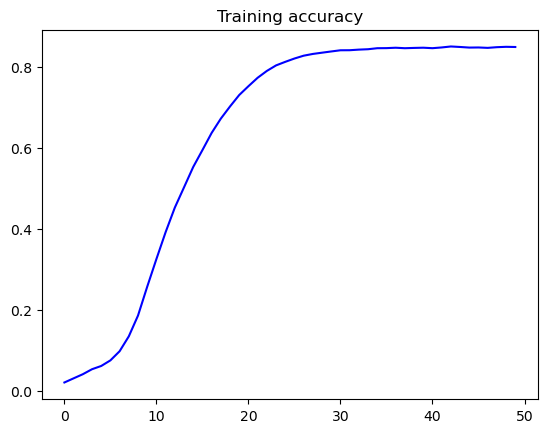

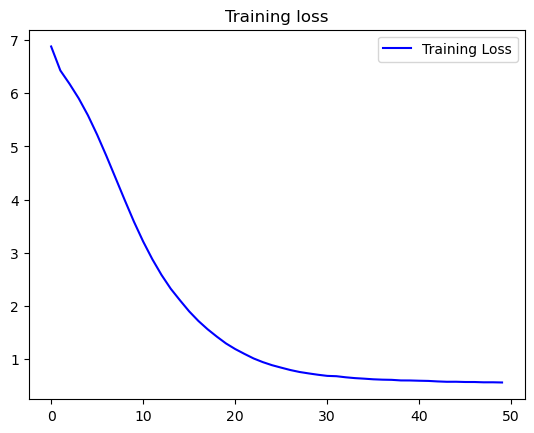

In [15]:
# Show the training curves of the model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [1]:
model.save('soneet_model.h5')

NameError: name 'model' is not defined

## Generating Sonnet using trained model 

In [18]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 50

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my heart you still seem wrong old back of me back again ere me now thou dost lie to thee thy face prove thee ere grace thy face she lie to me blind dost be old hell the lease of thy true love control be fair due and thee one
